In [1]:
!git clone https://github.com/davda54/sam


fatal: destination path 'sam' already exists and is not an empty directory.


In [2]:
import sys; sys.path.append("..")

sys.path.append("sam")
from sam import SAM

In [3]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
 # prime generating functions

# Python program to print prime factors
 
import math
 
# A function to print all prime factors of
# a given number n
def primeFactors(n):
    fact_array = []
    # Print the number of two's that divide n
    while n % 2 == 0:
        fact_array.append(2)
        n = n / 2
         
    # n must be odd at this point
    # so a skip of 2 ( i = i + 2) can be used
    for i in range(3,int(math.sqrt(n))+1,2):
         
        # while i divides n , print i and divide n
        while n % i== 0:
            fact_array.append(i)
            n = n / i
             
    # Condition if n is a prime
    # number greater than 2
    if n > 2:
        fact_array.append(n)
    return fact_array


def isPrime(n):
  fact_array = primeFactors(n)
  if len(fact_array) == 1:
    return True
  return False


#primes up to 
def primes_upto(limit):
    prime = [True] * limit
    for n in range(2, limit):
        if prime[n]:
            yield n # n is a prime
            for c in range(n*n, limit, n):
                prime[c] = False # mark composites


In [5]:
# encoding algorithm
def encode(batch, digits, base):
  s=batch.size(dim=0)
  t=base**torch.arange(digits-1,-1,-1).to(torch.int64)
  batch=torch.nn.functional.one_hot(torch.remainder(batch//t[None, :].to(torch.int64), base), num_classes=base)
  batch=torch.reshape(batch, (s, digits*base))
  return(batch)

def decode(batch, digits, syst):
  batch=(torch.argmax(batch, dim=2)@t)[:, None]
  return(batch)

In [6]:
np.random.seed(seed=1372022)
N=999
base = 10
digits = base*(math.floor(np.log(N)/np.log(base))+1)

train_primes = list(primes_upto(N+1))
#train_composites = [i for i in range(1000) if i not in train_primes]
all_data = []
for k in range(N//len(train_primes)):
    all_data += [tuple((i, 1)) for i in range(1,N+1) if i in train_primes]
all_data += [tuple((i, 0)) for i in range(1,N+1) if i not in train_primes]

# all_data = [tuple((i, 1)) for i in range(1,N+1) if i in train_primes] + [tuple((i, 0)) for i in range(1,N+1) if i not in train_primes if np.random.uniform(0, 1)<len(train_primes)/N]

np.random.shuffle(all_data)

train_data = all_data[: math.floor(len(all_data)*0.8)]
test_data = set(all_data[math.floor(len(all_data)*0.8):])
test_data.difference(set(train_data))
test_data = list(test_data)

In [7]:
counter_primes = 0
counter = 0
for i in all_data:
    if i[1]:
        counter_primes += 1
    else:
        counter += 1
print(counter_primes, counter)

print(train_data[:20])
print(len(train_data))
print(len(test_data))

840 831
[(593, 1), (932, 0), (229, 1), (772, 0), (835, 0), (461, 1), (214, 0), (643, 1), (822, 0), (563, 1), (39, 0), (839, 1), (947, 1), (727, 1), (522, 0), (389, 1), (181, 1), (36, 0), (991, 1), (353, 1)]
1336
275


In [8]:
#model
input = base*digits
output1 = 64
output2 = 128
output3 = 64
class MLP(nn.Module):
    def __init__(self,output1,output2, output3):
        super().__init__()
        self.step1 = nn.Linear(input, output1)
        self.step2 = nn.Linear(output1, output2)
        self.step3 = nn.Linear(output2, 1)

    def forward(self, x):
        
        x = self.step1(x)
        x = F.relu(x)
        x = self.step2(x)
        x = F.relu(x)
        #x = self.step3(x)
        #x = F.relu(x)
        x = self.step3(x)

        return x

In [62]:
def train_MLP(batch_size=32, epochs=10, tracking=False, div_tracking=False, divisor=2):
  from torchvision import datasets, transforms
  from tqdm.notebook import tqdm, trange

  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
  val_loader = torch.utils.data.DataLoader(test_data, shuffle=False)

  ## Training
  # Instantiate model  
  model = MLP(output1, output2, output3).to(device) 

  # Loss and Optimizer
  base_optimizer = torch.optim.SGD
  optimizer = SAM(model.parameters(), base_optimizer,rho=0.05, lr = 0.01, momentum=0.9, weight_decay=0.0005)
  # optimizer = SAM(model.parameters(), base_optimizer, lr = 0.01)
  criterion = nn.BCEWithLogitsLoss()

  training_losses = []
  training_accuracies = []
  validation_accuracies = []


  div_list = []



  # Iterate through train set minibatchs 
  for epoch in trange(epochs):  
      per_epoch_loss = 0
      correct = 0
      for numbers, labels in train_loader:
          x = numbers[:,None]
          x = x.to(device)
          x = encode(x, digits, base).float()
          labels = labels.double().to(device)[:,None]
          # Zero out the gradients
          optimizer.zero_grad()

          def closure():
            loss = criterion(model(x), labels)
            loss.backward()
            return loss

          # Forward pass
          y = model(x)
          loss = criterion(y, labels)
          if tracking:
            # Tracking loss
            per_epoch_loss += loss

            # Train accuracy tracking
            predictions = ((y>0)*1)
            correct += torch.sum((predictions == labels).float())

            # Validation accuracy tracking


          loss.backward()
          optimizer.step(closure)
      if tracking:
        correct_test = 0
        with torch.no_grad():
                # Iterate through test set minibatchs 
                for numbers2, labels2 in val_loader:
                    numbers2 = numbers2.to(device)
                    labels2 = labels2.double().to(device)[:,None]
                    # Forward pass
                    x2 = numbers2[:,None]
                    x2 = encode(x2, digits, base).float()
                    y2 = model(x2)
                    predictions2 = ((y2>0)*1)[:,0]
                    correct_test += torch.sum((predictions2 == labels2).float())

        training_losses.append(per_epoch_loss/len(train_loader))
        training_accuracies.append(correct/len(train_data))
        validation_accuracies.append(correct_test/len(test_data))
      if div_tracking:
        correct_div = 0
        with torch.no_grad():
                list_div = [i for i in range(divisor, N, divisor)]
                test_div = [(divisor,isPrime(divisor))] + [(number, 0) for number in list_div[1:]]
                # Iterate through test set minibatchs 
                div_loader = torch.utils.data.DataLoader(test_div, shuffle=False)
                for numbers3, labels3 in div_loader:
                    numbers3 = numbers3.to(device)
                    labels3 = labels3.double().to(device)[:,None]
                    # Forward pass
                    x3 = numbers3[:,None]
                    x3 = encode(x3, digits, base).float()
                    y3 = model(x3)
                    predictions3 = ((y3>0)*1)[:,0]
                    correct_div += torch.sum((predictions3 == labels3).float())

        div_list.append(1-correct_div/len(test_div))
  training_losses = [i.item() for i in training_losses]
  training_accuracies = [i.item() for i in training_accuracies]
  validation_accuracies = [i.item() for i in validation_accuracies]

  return model, training_losses, training_accuracies, validation_accuracies, div_list


In [65]:
model, training_losses, training_accuracies, validation_accuracies, div_list = train_MLP(batch_size=32, epochs=10, tracking=True, div_tracking=True, divisor=2)
print(div_list)

<ipython-input-5-5e5797f04886>:5: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  batch=torch.nn.functional.one_hot(torch.remainder(batch//t[None, :].to(torch.int64), base), num_classes=base)



[tensor(0.0020), tensor(0.3447), tensor(0.8337), tensor(0.0401), tensor(0.0020), tensor(0.3447), tensor(0.0261), tensor(0.0020), tensor(0.0020), tensor(0.0020)]


In [66]:
# ## Testing
# correct = 0
# total = len(test_data)

# with torch.no_grad():
#     # Iterate through test set minibatchs 
#     for numbers, labels in tqdm(test_loader):
#         numbers = numbers.to(device)
#         labels = labels.to(device)
#         # Forward pass
#         x = numbers[:,None]
#         x = encode(x, digits, base).float()
#         y = model(x)
#         predictions = ((y>0)*1)[:, 0]
#         correct += torch.sum((predictions == labels).float())

# print('Test accuracy: {}'.format(correct/total))

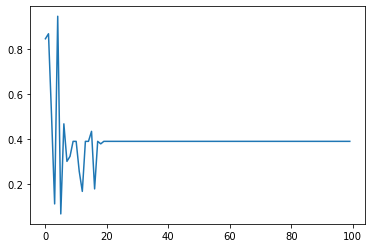

In [50]:
plt.plot([i.item() for i in div_list])

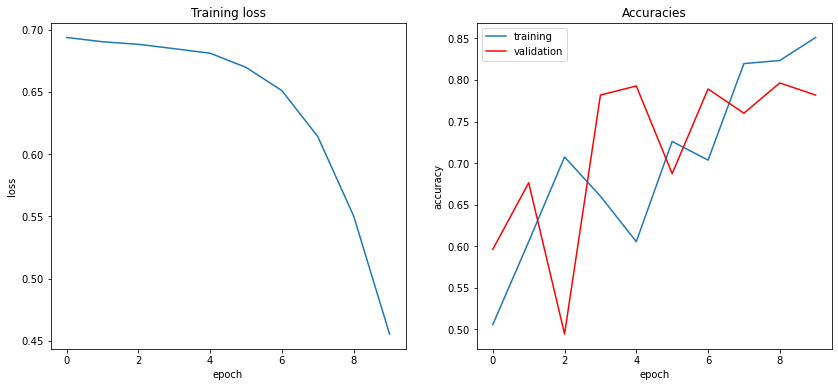

In [70]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(training_losses)
plt.title('Training loss')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(1, 2, 2)
plt.plot(training_accuracies, label='training')
plt.plot(validation_accuracies, color = 'red', label='validation')
plt.title('Accuracies')
plt.legend(loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()


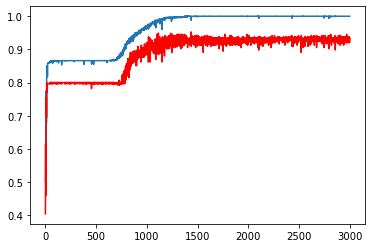

In [12]:
plt.plot([i.item() for i in training_accuracies])
plt.plot([i.item() for i in validation_accuracies], color = 'red')

<ipython-input-5-5e5797f04886>:5: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  batch=torch.nn.functional.one_hot(torch.remainder(batch//t[None, :].to(torch.int64), base), num_classes=base)


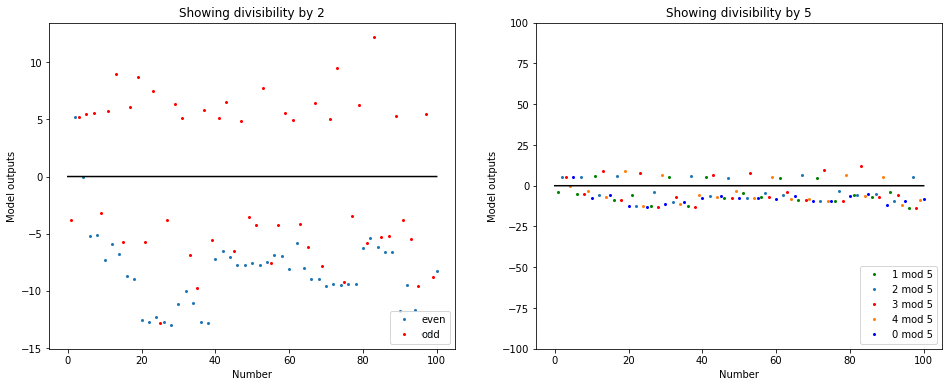

In [21]:
preds = [float(model(encode(torch.tensor([[i]]), digits, base).float())) for i in range(1,N+1)]

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, N+1)[1:100:2], preds[1:100:2], 'o', markersize = 2, label="even")
plt.plot(range(1, N+1)[0:100:2], preds[0:100:2], 'ro', markersize = 2, label="odd")
#plt.ylim([-100, 100])
plt.plot(np.linspace(0, 100, 10000), np.zeros(10000), color='black')
plt.xlabel('Number')
plt.ylabel('Model outputs')
plt.title('Showing divisibility by 2')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
# plt.plot(range(1, N+1)[1:100:3], preds[1:100:3], 'ro', markersize = 2, label="0 mod 3")
plt.plot(range(1, N+1)[0:100:5], preds[0:100:5], 'go', markersize = 2, label="1 mod 5")
plt.plot(range(1, N+1)[1:100:5], preds[1:100:5], 'o', markersize = 2, label="2 mod 5")
plt.plot(range(1, N+1)[2:100:5], preds[2:100:5], 'ro', markersize = 2, label="3 mod 5")
plt.plot(range(1, N+1)[3:100:5], preds[3:100:5], 'o', markersize = 2, label="4 mod 5")
plt.plot(range(1, N+1)[4:100:5], preds[4:100:5], 'bo', markersize = 2, label="0 mod 5")
plt.ylim([-100, 100])
plt.plot(np.linspace(0, 100, 10000), np.zeros(10000), color='black')
plt.xlabel('Number')
plt.ylabel('Model outputs')
plt.title('Showing divisibility by 5')
plt.legend(loc='lower right')
plt.show()



In [58]:
print([index+1 for index, i in enumerate(preds) if i<0 if index%2==0][:20])
print([[index+1]+primeFactors(index+1) for index, i in enumerate(preds) if i > 0 if not isPrime(index+1)])
print([index+1 for index, i in enumerate(preds) if i < 0 if isPrime(index+1)])

[1, 9, 15, 21, 25, 27, 33, 35, 39, 45, 49, 51, 55, 57, 63, 65, 69, 75, 77, 81]
[[183, 3, 61.0], [243, 3, 3, 3, 3, 3], [309, 3, 103.0], [319, 11, 29.0], [371, 7, 53.0], [377, 13, 29.0], [427, 7, 61.0], [429, 3, 11, 13], [447, 3, 149.0], [581, 7, 83.0], [671, 11, 61.0], [731, 17, 43.0], [737, 11, 67.0], [753, 3, 251.0], [767, 13, 59.0], [849, 3, 283.0], [927, 3, 3, 103.0], [949, 13, 73.0]]
[]


In [23]:
## Testing
correct = 0
total = len(train_data)

with torch.no_grad():
    # Iterate through test set minibatchs 
    for numbers, labels in tqdm(train_loader):
        numbers = numbers.to(device)
        labels = labels.to(device)
        # Forward pass
        x = numbers[:,None]
        x = encode(x, digits, base).float()
        y = model(x)

        predictions = ((y>0)*1)[:, 0]
        correct += torch.sum((predictions == labels).float())

print('Train accuracy: {}'.format(correct/total))


Train accuracy: 1.0


<ipython-input-5-5e5797f04886>:5: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  batch=torch.nn.functional.one_hot(torch.remainder(batch//t[None, :].to(torch.int64), base), num_classes=base)


In [57]:
x = torch.tensor([[77]])

x = encode(x, digits, base).float()
model(x)

<ipython-input-5-5e5797f04886>:5: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  batch=torch.nn.functional.one_hot(torch.remainder(batch//t[None, :].to(torch.int64), base), num_classes=base)


tensor([[1.7959]], grad_fn=<AddmmBackward0>)